In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:99% !important; }</style>"))

In [2]:
import numpy as np
from astropy.table import Table
from astropy.io import ascii 
from astropy.wcs import WCS
import astropy.io.fits as pyfits
from astropy.utils.data import get_pkg_data_filename
from collections import Counter


from astropy.convolution import Gaussian2DKernel
from scipy.signal import convolve as scipy_convolve
from astropy.convolution import convolve_fft
from scipy import ndimage, misc


import matplotlib.pyplot as plt 
import matplotlib.cm as cm # colormaps
import matplotlib.colors as colors
import astropy.io.fits as pyfits
from matplotlib.gridspec import GridSpec
import matplotlib as mpl

import pandas as pd


import os

In [3]:
#import FITS_tools #https://github.com/keflavich/FITS_tools/tree/master/FITS_tools
from reproject import reproject_interp


In [4]:
os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ')

#70um
hers_70um_hdu = pyfits.open(get_pkg_data_filename('./FITS/destripe_l000_blue_wgls_rcal_cropped.fits'))[0]

#70um SMOOTHED
hers_70um_smoothed_hdu = pyfits.open(get_pkg_data_filename('./FITS/herschel70um_cutout_FFT_smoothed_3arcmin_normed_kernel.fits'))[0]

#Sources to nans
hers_sources_removed_map_FITS = pyfits.open(get_pkg_data_filename('./FITS/70um_sources_to_nans.fits'))[0]

#herschel col den
hers_col_den = pyfits.open('./FITS/destripe_l000_blue_wgls_rcal_cropped.fits')[0]

In [5]:
#Load in table that has the cloud names and leaf ids 
os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ')
leaf_tab = Table.read('./corr_coeff_table.tex')
cloud_leafs = leaf_tab['coeff leaf ids']
cloud_names = leaf_tab['cloud list']


cat_tab = Table.read('./LBV_plots_stuff/CMZ_cloud_catalogue_data.csv')
cat_index = cat_tab['index']
cat_v = cat_tab['v']




In [6]:
#find indexes with multiple velocities 
dup = {x for x in list(cat_index) if list(cat_index).count(x) > 1}

dup_index =[]
for i in range(len(cat_index)):
    if cat_index[i] in dup:
        dup_index.append(i)


id_list = []
for i in dup_index:
    id_list.append('{}_{}'.format(cat_index[i], cat_v[i]))

# mom0 Masks

In [7]:
for p in dup_index:
    os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks')
    os.chdir('{}/mom0_submask'.format(cat_index[p]))

    id_index = np.where(cloud_leafs == int(cat_index[p]))
    cloud_name = cloud_names[id_index][0]
        
    #load in the 70um sources to nans cutout for cloud
    sources_removed_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel70um_sources_to_nans_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]
    
    #load in 70um smoothed cutout for cloud
    smoothed_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]

    #load in herschel cutout for cloud
    hers_regrid_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_70um.fits'.format(cloud_name, cloud_name)))[0]

    #load in FLUX DIFF cutout for cloud 
    flux_diff_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_flux_diff.fits'.format(cloud_name, cloud_name)))[0]

    #load in FLUX RATIO cutout for cloud 
    flux_ratio_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_flux_ratio.fits'.format(cloud_name, cloud_name)))[0]
    

    
    
    #Get sub mask file
    mask_hdu = pyfits.open('../../mom0/{}_{}_HNCO_cube_mom0.mask.fits'.format(cat_index[p], cat_v[p]))[0]
    

    
    

    regrid_mask_array, regrid_mask_footprint = reproject_interp(mask_hdu, sources_removed_cutout_hdu.header)
    
    regrid_8um_mask_array, regrid_8um_mask_footprint = reproject_interp(mask_hdu, flux_diff_cutout_hdu.header)
    #pyfits.writeto('{}_HNCO_cube_mom0_reproject.mask.fits'.format(ID), regrid_mask_array, hers_70um_hdu.header, overwrite=True)
    
    
    
    
    
    
    #Herschel 70um cutout
    hers70_masked = np.empty(sources_removed_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(sources_removed_cutout_hdu.data[i[0]][i[1]]):
            hers70_masked[i[0]][i[1]] = sources_removed_cutout_hdu.data[i[0]][i[1]]
        else:
            hers70_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_hers70_sources_to_nans_mom0cutout_isolated.fits'.format(cat_index[p], cat_v[p]), hers70_masked, sources_removed_cutout_hdu.header, overwrite=True)


    
    
    #Herschel 70um SMOOTHED cutout
    hers70_smoothed_masked = np.empty(smoothed_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(smoothed_cutout_hdu.data[i[0]][i[1]]):
            hers70_smoothed_masked[i[0]][i[1]] = smoothed_cutout_hdu.data[i[0]][i[1]]
        else:
            hers70_smoothed_masked[i[0]][i[1]] = float('nan')

    pyfits.writeto('{}_{}_hers70_smoothed_mom0cutout_isolated.fits'.format(cat_index[p], cat_v[p]), hers70_smoothed_masked, smoothed_cutout_hdu.header, overwrite=True)



    
    
    #Herschel Col Den cutout
    hers_regrid_masked = np.empty(hers_regrid_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(hers_regrid_cutout_hdu.data[i[0]][i[1]]):
            hers_regrid_masked[i[0]][i[1]] = hers_regrid_cutout_hdu.data[i[0]][i[1]]
        else:
            hers_regrid_masked[i[0]][i[1]] = float('nan')

    pyfits.writeto('{}_{}_hers_mom0cutout_isolated.fits'.format(cat_index[p], cat_v[p]), hers_regrid_masked, hers_regrid_cutout_hdu.header, overwrite=True)


    
        
    
    #8UM FLUX DIFF CUTOUT
    flux_diff_masked = np.empty(flux_diff_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(flux_diff_cutout_hdu.data[i[0]][i[1]]):
            flux_diff_masked[i[0]][i[1]] = flux_diff_cutout_hdu.data[i[0]][i[1]]
        else:
            flux_diff_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_flux_diff_mom0cutout_isolated.fits'.format(cat_index[p], cat_v[p]), flux_diff_masked, flux_diff_cutout_hdu.header, overwrite=True)
    
    
    #8UM FLUX RATIO CUTOUT
    flux_ratio_masked = np.empty(flux_ratio_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(flux_ratio_cutout_hdu.data[i[0]][i[1]]):
            flux_ratio_masked[i[0]][i[1]] = flux_ratio_cutout_hdu.data[i[0]][i[1]]
        else:
            flux_ratio_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_flux_ratio_mom0cutout_isolated.fits'.format(cat_index[p], cat_v[p]), flux_ratio_masked, flux_ratio_cutout_hdu.header, overwrite=True)

# Max Masks

In [92]:
for p in dup_index:
    os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks')
    os.chdir('{}/max_submask'.format(cat_index[p]))

    id_index = np.where(cloud_leafs == int(cat_index[p]))
    cloud_name = cloud_names[id_index][0]
        
    #load in the 70um sources to nans cutout for cloud
    sources_removed_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel70um_sources_to_nans_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]
    
    #load in 70um smoothed cutout for cloud
    smoothed_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel70um_SMOOTHED_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]
    
    #load in herschel cutout for cloud
    hers_regrid_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_70um.fits'.format(cloud_name, cloud_name)))[0]

    #load in FLUX DIFF cutout for cloud 
    flux_diff_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_flux_diff.fits'.format(cloud_name, cloud_name)))[0]

    #load in FLUX RATIO cutout for cloud 
    flux_ratio_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_flux_ratio.fits'.format(cloud_name, cloud_name)))[0]
    
    #load in 8um intensity cutout
    spitz_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_spitzer_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]
    
    #load in 8um smoothed background cutout 
    spitz_smoothed_cutout_hdu =  pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_smoothed_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]
    
    
    #load in 8um RAW cutout 
    spitz_RAW_cutout_hdu =  pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_spitzer_RAW_cutout_isolated.fits'.format(cloud_name, cloud_name)))[0]
    
        

    mask_hdu = pyfits.open('../../max/{}_{}_HNCO_cube_max.mask.fits'.format(cat_index[p], cat_v[p]))[0]
    

    
    

    regrid_mask_array, regrid_mask_footprint = reproject_interp(mask_hdu, sources_removed_cutout_hdu.header)
    
    regrid_8um_mask_array, regrid_8um_mask_footprint = reproject_interp(mask_hdu, flux_diff_cutout_hdu.header)

    #pyfits.writeto('{}_HNCO_cube_mom0_reproject.mask.fits'.format(ID), regrid_mask_array, hers_70um_hdu.header, overwrite=True)
    
    
    
    
    
    
    #Herschel 70um cutout
    hers70_masked = np.empty(sources_removed_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(sources_removed_cutout_hdu.data[i[0]][i[1]]):
            hers70_masked[i[0]][i[1]] = sources_removed_cutout_hdu.data[i[0]][i[1]]
        else:
            hers70_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_hers70_sources_to_nans_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), hers70_masked, sources_removed_cutout_hdu.header, overwrite=True)


    
    
    #Herschel 70um SMOOTHED cutout
    hers70_smoothed_masked = np.empty(smoothed_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(smoothed_cutout_hdu.data[i[0]][i[1]]):
            hers70_smoothed_masked[i[0]][i[1]] = smoothed_cutout_hdu.data[i[0]][i[1]]
        else:
            hers70_smoothed_masked[i[0]][i[1]] = float('nan')

    pyfits.writeto('{}_{}_hers70_smoothed_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), hers70_smoothed_masked, smoothed_cutout_hdu.header, overwrite=True)


    #Herschel Col Den cutout
    hers_regrid_masked = np.empty(hers_regrid_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(hers_regrid_cutout_hdu.data[i[0]][i[1]]):
            hers_regrid_masked[i[0]][i[1]] = hers_regrid_cutout_hdu.data[i[0]][i[1]]
        else:
            hers_regrid_masked[i[0]][i[1]] = float('nan')

    pyfits.writeto('{}_{}_hers_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), hers_regrid_masked, hers_regrid_cutout_hdu.header, overwrite=True)


        
    
    #8UM FLUX DIFF CUTOUT
    flux_diff_masked = np.empty(flux_diff_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(flux_diff_cutout_hdu.data[i[0]][i[1]]):
            flux_diff_masked[i[0]][i[1]] = flux_diff_cutout_hdu.data[i[0]][i[1]]
        else:
            flux_diff_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_flux_diff_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), flux_diff_masked, flux_diff_cutout_hdu.header, overwrite=True)
    
    
    #8UM FLUX RATIO CUTOUT
    flux_ratio_masked = np.empty(flux_ratio_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(flux_ratio_cutout_hdu.data[i[0]][i[1]]):
            flux_ratio_masked[i[0]][i[1]] = flux_ratio_cutout_hdu.data[i[0]][i[1]]
        else:
            flux_ratio_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_flux_ratio_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), flux_ratio_masked, flux_ratio_cutout_hdu.header, overwrite=True)
    
    
    
    #8UM INTESITY CUTOUT
    spitz_masked = np.empty(spitz_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(spitz_cutout_hdu.data[i[0]][i[1]]):
            spitz_masked[i[0]][i[1]] = spitz_cutout_hdu.data[i[0]][i[1]]
        else:
            spitz_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_spitz_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), spitz_masked, spitz_cutout_hdu.header, overwrite=True)

    #8UM SMOOTHED CUTOUT
    spitz_smoothed_masked = np.empty(spitz_smoothed_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(spitz_smoothed_cutout_hdu.data[i[0]][i[1]]):
            spitz_smoothed_masked[i[0]][i[1]] = spitz_smoothed_cutout_hdu.data[i[0]][i[1]]
        else:
            spitz_smoothed_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_spitz_smoothed_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), spitz_smoothed_masked, spitz_smoothed_cutout_hdu.header, overwrite=True)
    
    
    
    #8UM RAW CUTOUT
    spitz_RAW_masked = np.empty(spitz_RAW_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_8um_mask_array):
        if m > 0 and not np.isnan(spitz_RAW_cutout_hdu.data[i[0]][i[1]]):
            spitz_RAW_masked[i[0]][i[1]] = spitz_RAW_cutout_hdu.data[i[0]][i[1]]
        else:
            spitz_RAW_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_spitz_RAW_maxcutout_isolated.fits'.format(cat_index[p], cat_v[p]), spitz_RAW_masked, spitz_RAW_cutout_hdu.header, overwrite=True)

# Weighted Masks (mask the ExtN!!)

In [ ]:
for p in dup_index:
    os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks')
    os.chdir('{}/weighted_submask'.format(cat_index[p]))

    id_index = np.where(cloud_leafs == int(cat_index[p]))
    cloud_name = cloud_names[id_index][0]

        
    #load in the 70um ExtN with ffore=0.5
    ExtN_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_70umExtN_ffore0.50_tonans.fits'.format(cloud_name, cloud_name)))[0]
    

    
    #load in herschel cutout for cloud
    hers_regrid_cutout_hdu = pyfits.open(get_pkg_data_filename('../../../Cloud_masks/{}/{}_herschel_cutout_isolated_regrid_to_70um.fits'.format(cloud_name, cloud_name)))[0]

    mask_hdu = pyfits.open('../../weighted_masks/{}_{}_HNCO_cube_max.mask.fits'.format(cat_index[p], cat_v[p]))[0]
    


    

    regrid_mask_array, regrid_mask_footprint = reproject_interp(mask_hdu, ExtN_cutout_hdu.header)
    #pyfits.writeto('{}_HNCO_cube_mom0_reproject.mask.fits'.format(ID), regrid_mask_array, hers_70um_hdu.header, overwrite=True)
    
    
    
    
    
    
    #70um ExtN
    ExtN_masked = np.empty(ExtN_cutout_hdu.data.shape)
    for i, m in np.ndenumerate(regrid_mask_array):
        if m > 0 and not np.isnan(ExtN_cutout_hdu.data[i[0]][i[1]]):
            ExtN_masked[i[0]][i[1]] = m*ExtN_cutout_hdu.data[i[0]][i[1]]
        else:
            ExtN_masked[i[0]][i[1]] = float('nan')

             
    pyfits.writeto('{}_{}_70umExtN_weighted_ffore{:.2f}.fits'.format(cat_index[p], cat_v[p],0.50), ExtN_masked, ExtN_cutout_hdu.header, overwrite=True)
    
    



# SubMask ExtvsEm Col Den Calculations

In [7]:
#Feb 27th, 2023 Redid all the dumb geometry that was previous done Feb 27th, 2009...
#GAH! Law of cosines!

#Distribution of stars proportional to e^-(R/h_{R})
def disk_dist(d, n0, l):
    R_sun = 8.4 #kpc
    h_R = 3.5 #Galactic radial scale in kpc
    R = np.sqrt(d**2 + R_sun**2 -(2*d*R_sun*np.cos(np.deg2rad(l))))    

    return n0 * np.exp(-R/h_R)##Function to automate 70um fits##

#define extinction function
#f_fore is the fraction of LOS emission from foreground
#I_0_obs is intensity behind cloud
#I_1_obs is intensity in front of cloud
def Sigma_70um(f_fore, I_0_obs, I_1_obs):
    k_v = 1.74 #cm^2/g #dust opacity for 70um
    return (-1./k_v) * np.log(  (I_1_obs - (f_fore*I_0_obs)) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???


#If the front of cloud intensity is much larger than the assumed background, the log() will be positive
#And the sigma will come out negative

#Will return nans if doing log of negative number (i.e. if the background is MUCH higher than the front of
#the cloud)

In [8]:
#Convert to col den = (Sigma/mu*m_H)
def N(sig):
    mu = 2.8
    m_H = 1.67e-24 #g
    return sig/(mu*m_H)



def cloud_extinction_calc_70um(hers, f_fore, smoothed, obs):
    #Create list to populate 
    Sigma = np.zeros(shape=(len(hers),len(hers[0])))
    ext_N = np.zeros(shape=(len(hers),len(hers[0])))
    
    #For-loop for 2D array, first y then x
    for i in np.arange(len(hers)):

        for j in np.arange(len(hers[0])):
            if smoothed[i][j] == np.NaN:
                Sigma[i][j] = np.NaN
                ext_N[i][j] = np.NaN

            else:
                sig = Sigma_70um(f_fore, smoothed[i][j], obs[i][j])
                Sigma[i][j] = sig
                ext_N[i][j] = N(sig)
                
    return ext_N

In [9]:
##Function to calculate and create plots##


    
def cloud_EmvsExt_submasks(ID, mask_id, f_fore, submask_type):
    os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks')

    ###Import Files###

    cloud_70um_tonans = pyfits.open('{}/{}_submask/{}_hers70_sources_to_nans_{}cutout_isolated.fits'.format(ID,submask_type,mask_id,submask_type))[0]
    cloud_70um_smoothed =pyfits.open('{}/{}_submask/{}_hers70_smoothed_{}cutout_isolated.fits'.format(ID,submask_type,mask_id,submask_type))[0]
    cloud_hers_regrid_70 = pyfits.open('{}/{}_submask/{}_hers_{}cutout_isolated.fits'.format(ID,submask_type,mask_id,submask_type))[0]

    #Get the avg column density from herschel
    cloud_avg_hers= np.nanmean(cloud_hers_regrid_70.data) #finds average ignoring nans

    #Calculate a 2D array for the whole cloud#
    cloud_ext_N = cloud_extinction_calc_70um(cloud_hers_regrid_70.data, f_fore, cloud_70um_smoothed.data, cloud_70um_tonans.data)




    pyfits.writeto('{}/{}_submask/{}_70umExtN_{}_ffore{:.2f}.fits'.format(ID,submask_type,mask_id,submask_type,f_fore), cloud_ext_N, cloud_70um_tonans.header, overwrite=True)

    
    return 




In [10]:
for p in range(len(dup_index)):
    id_index = np.where(cloud_leafs == int(cat_index[p]))
    cloud_name = cloud_names[id_index][0]
    
    
    cloud_EmvsExt_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'mom0')
    cloud_EmvsExt_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'max')


/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_40535/398044764.py:18: RuntimeWarning: invalid value encountered in log
  return (-1./k_v) * np.log(  (I_1_obs - (f_fore*I_0_obs)) / ( (1-f_fore)*I_0_obs  ) ) #g/cm^2???
/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_40535/3734977773.py:15: RuntimeWarning: Mean of empty slice
  cloud_avg_hers= np.nanmean(cloud_hers_regrid_70.data) #finds average ignoring nans


# Convolve and Regrid to Hers Col Den

In [11]:
def convolve_regrid_submasks(ID, mask_id, f_fore, submask_type):
    os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks')
    #Want to match 36" convolution, hers 70um resolution is 6"
    higal_colden_res = 36 /2.355 #sigma = FWHM/sqrt(8ln2) = FWHM/2.355
    highal70_res = 6/2.355

    sig_gauss = np.sqrt(higal_colden_res**2 - highal70_res**2 )
    kern = sig_gauss/(3.2) #arcsec/pix
    

    #Load in ExtN file
    ExtFile = pyfits.open('{}/{}_submask/{}_70umExtN_{}_ffore{:.2f}.fits'.format(ID,submask_type,mask_id,submask_type,f_fore))[0] 
    
    
    #Convolve to Herschel Col Den
    convolved = convolve_fft(ExtFile.data, Gaussian2DKernel(x_stddev=kern), 
                             normalize_kernel=True, preserve_nan=True, allow_huge=True)


    pyfits.writeto('{}/{}_submask/{}_ExtN70um_{}_ffore{:.2f}_conv36.fits'.format(ID,submask_type, mask_id, submask_type, f_fore), 
                   convolved, ExtFile.header, overwrite=True) 
    
    
    
    
    
    #Regrid to Herschel Col Den
    #Load in the convolved file
    conv_file = pyfits.open('{}/{}_submask/{}_ExtN70um_{}_ffore{:.2f}_conv36.fits'.format(ID,submask_type, mask_id, submask_type, f_fore))[0]
    
    #load in the cutout herschel file we want to regrid to
    
    
    id_index = np.where(cloud_leafs == int(ID))
    cloud_name = cloud_names[id_index][0]   
    
    cloud_hers_cutout = pyfits.open('../Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud_name, cloud_name))[0]
    
    regrid_array, regrid_footprint = reproject_interp(conv_file, cloud_hers_cutout.header)
    
    pyfits.writeto('{}/{}_submask/{}_ExtN70um_{}_ffore{:.2f}_conv36_regrid.fits'.format(ID,submask_type, mask_id, submask_type, f_fore), 
                   regrid_array, cloud_hers_cutout.header, overwrite=True)    
    
    

In [12]:
for p in range(len(dup_index)):

        
    convolve_regrid_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'mom0')
    convolve_regrid_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'max')
    convolve_regrid_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'weighted')


# Calc and save corr_coeffs

In [12]:
corr_coeff_p_mom0 = []
corr_coeff_s_mom0 = []

corr_coeff_p_max = []
corr_coeff_s_max = []


def calc_corr_coeffs_submasks(ID, mask_id, f_fore, submask_type):

    os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks')
    #Load in files
    
    id_index = np.where(cloud_leafs == int(ID))
    cloud_name = cloud_names[id_index][0]   
    
    regrided_ExtN =pyfits.open('{}/{}_submask/{}_ExtN70um_{}_ffore{:.2f}_conv36_regrid.fits'.format(ID,submask_type, mask_id, submask_type, f_fore))[0]
    cloud_hers = pyfits.open('../Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud_name, cloud_name))[0]


    
    

    
    
    #CORR COEFF
    xy_p = pd.DataFrame({'Herschel': cloud_hers.data.flatten(), 'Ext Col Den': regrided_ExtN.data.flatten()})
    corr_coeff_p = (xy_p['Herschel'].corr(xy_p['Ext Col Den'], method='pearson'))


    xy_s = pd.DataFrame({'Herschel': cloud_hers.data.flatten(), 'Ext Col Den': regrided_ExtN.data.flatten()})
    corr_coeff_s = (xy_s['Herschel'].corr(xy_s['Ext Col Den'], method='spearman'))
    
    return round(corr_coeff_p,3), round(corr_coeff_s,3)
    
    

In [13]:
corr_coeff_p_mom0 = []
corr_coeff_s_mom0 = []

corr_coeff_p_max = []
corr_coeff_s_max = []

for p in range(len(dup_index)):
        
    r_p_mom0, r_s_mom0 = calc_corr_coeffs_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'mom0')
    corr_coeff_p_mom0.append(r_p_mom0)
    corr_coeff_s_mom0.append(r_s_mom0)
    
    r_p_max, r_s_max = calc_corr_coeffs_submasks(cat_index[dup_index[p]], id_list[p], 0.5, 'max')
    corr_coeff_p_max.append(r_p_max)
    corr_coeff_s_max.append(r_s_max)
    
    

/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [14]:
cat_tab = Table.read("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex")

#cat_tab.add_column(np.full(len(cat_tab),np.nan), name = 'r_p_mom0')
#cat_tab.add_column(np.full(len(cat_tab),np.nan), name = 'r_s_mom0')
#cat_tab.add_column(np.full(len(cat_tab),np.nan), name = 'r_p_max')
#cat_tab.add_column(np.full(len(cat_tab),np.nan), name = 'r_s_max')




cat_tab

index,cloud_name,l,b,v,sigma,rad,absorp,r_p_mom0,r_s_mom0,r_p_max,r_s_max,flux_diff_mom0,flux_ratio_mom0,I_cloud_max,I_model_max,flux_diff_max,flux_ratio_max,ext_frac_max,lb_pixel_mask,NF_decision,min_flux_max
str3,str14,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64
1,G359.475-0.044,-0.525,-0.044,-102,6,4.3,3,0.261,0.444,0.261,0.444,31.669,0.506,212.667,317.106,31.669,0.506,0.992,1,LN,82.971
2,G359.508-0.135,-0.492,-0.135,-56,9,8.7,3,0.384,0.397,0.384,0.397,-20.608,0.623,224.209,276.371,-20.608,0.623,0.815,1,N,117.934
3,G359.561-0.001,-0.439,-0.001,-90,8,2.7,0,0.222,0.325,0.222,0.325,-6.674,0.551,197.054,263.15,-6.674,0.551,0.997,1,U,106.365
4a,G359.595-0.223,-0.405,-0.223,-27,13,4.6,3,0.468,0.257,0.433,0.254,-27.454,0.569,180.619,232.561,-26.881,0.567,0.947,1,N,100.903
4b,G359.595-0.223,-0.405,-0.223,-20,8,4.6,3,0.316,0.329,0.262,0.101,-10.883,0.517,178.699,234.446,-25.555,0.559,0.932,0,LN,100.903
5,G359.608+0.018,-0.392,0.018,-78,5,2.0,1,0.183,0.262,0.183,0.262,-26.81,0.575,185.012,230.972,-26.81,0.575,0.997,1,LN,123.728
6a,G359.688-0.132,-0.312,-0.132,-29,5,5.6,0,0.655,0.694,0.621,0.621,-1.841,0.565,209.379,285.681,0.229,0.56,0.995,0,LN,153.898
6b,G359.688-0.132,-0.312,-0.132,-21,12,5.6,0,0.301,0.282,0.281,0.236,-8.637,0.579,202.07,259.951,-9.201,0.576,0.993,1,U,151.445
7a,G359.701+0.032,-0.299,0.032,-73,11,2.4,1,-0.53,-0.417,-0.535,-0.404,-45.38,0.658,205.206,233.126,-44.223,0.655,0.776,1,LN,154.551


In [15]:
cat_tab['r_p_mom0'][dup_index] = corr_coeff_p_mom0
cat_tab['r_s_mom0'][dup_index] = corr_coeff_s_mom0

cat_tab['r_p_max'][dup_index] = corr_coeff_p_max
cat_tab['r_s_max'][dup_index] = corr_coeff_s_max



cat_tab



index,cloud_name,l,b,v,sigma,rad,absorp,r_p_mom0,r_s_mom0,r_p_max,r_s_max,flux_diff_mom0,flux_ratio_mom0,I_cloud_max,I_model_max,flux_diff_max,flux_ratio_max,ext_frac_max,lb_pixel_mask,NF_decision,min_flux_max
str3,str14,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64
1,G359.475-0.044,-0.525,-0.044,-102,6,4.3,3,0.261,0.444,0.261,0.444,31.669,0.506,212.667,317.106,31.669,0.506,0.992,1,LN,82.971
2,G359.508-0.135,-0.492,-0.135,-56,9,8.7,3,0.384,0.397,0.384,0.397,-20.608,0.623,224.209,276.371,-20.608,0.623,0.815,1,N,117.934
3,G359.561-0.001,-0.439,-0.001,-90,8,2.7,0,0.222,0.325,0.222,0.325,-6.674,0.551,197.054,263.15,-6.674,0.551,0.997,1,U,106.365
4a,G359.595-0.223,-0.405,-0.223,-27,13,4.6,3,0.468,0.257,0.433,0.254,-27.454,0.569,180.619,232.561,-26.881,0.567,0.947,1,N,100.903
4b,G359.595-0.223,-0.405,-0.223,-20,8,4.6,3,0.316,0.329,0.262,0.101,-10.883,0.517,178.699,234.446,-25.555,0.559,0.932,0,LN,100.903
5,G359.608+0.018,-0.392,0.018,-78,5,2.0,1,0.183,0.262,0.183,0.262,-26.81,0.575,185.012,230.972,-26.81,0.575,0.997,1,LN,123.728
6a,G359.688-0.132,-0.312,-0.132,-29,5,5.6,0,0.655,0.694,0.621,0.621,-1.841,0.565,209.379,285.681,0.229,0.56,0.995,0,LN,153.898
6b,G359.688-0.132,-0.312,-0.132,-21,12,5.6,0,0.301,0.282,0.281,0.236,-8.637,0.579,202.07,259.951,-9.201,0.576,0.993,1,U,151.445
7a,G359.701+0.032,-0.299,0.032,-73,11,2.4,1,-0.53,-0.417,-0.535,-0.404,-45.38,0.658,205.206,233.126,-44.223,0.655,0.776,1,LN,154.551


In [16]:
#Find single v component clouds
single_v = {x for x in list(cat_index) if list(cat_index).count(x) == 1}
single_v

sing_index =[]
for i in range(len(cat_index)):
    if cat_index[i] in single_v:
        sing_index.append(i)

sing_index

[0, 1, 2, 5, 13, 14, 18, 19, 20, 21, 27, 28, 29, 32, 33, 34, 35, 38, 46]

In [17]:
#Fill in the single-component areas of the table
full_corr_tab = Table.read("/Users/danilipman/Documents/Research/UConn/3D_CMZ/corr_coeff_table.tex")
coeff_leaf_ids = full_corr_tab['coeff leaf ids']
r_p = full_corr_tab['p f05 all']
r_s = full_corr_tab['p f05 all spearman']


r_p_sing = []
r_s_sing =[]
for i in cat_tab['index'][sing_index]:
    ind = np.where(coeff_leaf_ids == i)
    r_p_sing.append(r_p[ind][0])
    r_s_sing.append(r_s[ind][0])


cat_tab['r_p_mom0'][sing_index] = r_p_sing
cat_tab['r_s_mom0'][sing_index] = r_s_sing

cat_tab['r_p_max'][sing_index] = r_p_sing
cat_tab['r_s_max'][sing_index] = r_s_sing

#cat_tab.write("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex", overwrite=True)

#cat_tab.write("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.csv", overwrite=True)


cat_tab

/opt/anaconda3/lib/python3.9/site-packages/astropy/table/column.py:329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = getattr(super(Column, self), op)(other)


IndexError: index 0 is out of bounds for axis 0 with size 0

# PLOT THE SUBPLOTS!!!!!

In [18]:
cat_index_reshape = cat_index[dup_index]
cat_index_reshape = np.reshape(cat_index_reshape,(4,7))

id_list_reshape = id_list
id_list_reshape = np.reshape(id_list,(4,7))

index_name_list = cat_tab['index'][dup_index]
index_name_list_reshape=np.reshape(index_name_list,(4,7))

In [19]:
def plot_all_the_subs(ID, mask_id, f_fore, submask_type):


    fig, ax = plt.subplots(4, 7, sharex=True, sharey=True, figsize = (30,15))

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlim(0,33)
    plt.ylim(-20,35)

  
    for i in range(4):
        for j in range(7):
            
            

            id_index = np.where(cloud_leafs == int(ID[i][j]))
            cloud_name = cloud_names[id_index][0]
            print(id_index, cloud_name)

            regrided_ExtN =pyfits.open('{}/{}_submask/{}_ExtN70um_{}_ffore{:.2f}_conv36_regrid.fits'.format(ID[i][j],submask_type, mask_id[i][j], submask_type, f_fore))[0]
            #print(mask_id[i][j],np.size(np.where(~np.isnan(regrided_ExtN.data) == True)))
            
            full_regridded_ExtN = pyfits.open('../Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud_name, cloud_name, f_fore))[0]

            cloud_hers = pyfits.open('../Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud_name, cloud_name))[0]

            wcs = WCS(regrided_ExtN.header)
            
            
            
            #Calculate corr coeff
            
            corr_coeff_p = []
            corr_coeff_s = []
            xy_p = pd.DataFrame({'Herschel': cloud_hers.data.flatten(), 'Ext Col Den': regrided_ExtN.data.flatten()})
            corr_coeff_p.append(xy_p['Herschel'].corr(xy_p['Ext Col Den'], method='pearson'))
            
            
            xy_s = pd.DataFrame({'Herschel': cloud_hers.data.flatten(), 'Ext Col Den': regrided_ExtN.data.flatten()})
            corr_coeff_s.append(xy_s['Herschel'].corr(xy_s['Ext Col Den'], method='pearson'))
            

            plt.rcParams.update({'font.size': 17})

            
        

            x = np.arange(-1,30)
            y = np.arange(-1,30)



            ax[i,j].scatter(cloud_hers.data/1E22,regrided_ExtN.data/1E22, 
                    marker='+', color = 'r', alpha=0.5, label = "f_fore={}".format(f_fore),zorder=10)

            ax[i,j].scatter(cloud_hers.data/1E22,full_regridded_ExtN.data/1E22, 
                    marker='*', color = 'gray', alpha=0.1, label = "f_fore={}".format(f_fore), zorder=0)
            
            

            ax[i,j].plot(x,y, c='black')
            ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')

            #plt.legend(loc=2)
            #ax[i,j].text(.05, .97, '{} ({})'.format(mask_id[i][j], cloud_name), ha='left', va='top', transform=ax[i,j].transAxes)
            ax[i,j].text(.05, .97, 'Cloud Leaf ID: {}'.format(index_name_list_reshape[i][j]), ha='left', va='top', transform=ax[i,j].transAxes)
            ax[i,j].text(.05, .89, 'r = {:.3f}'.format(corr_coeff_p[0]), ha='left', va='top', transform=ax[i,j].transAxes)
            
    fig.text(0.5, 0.05, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$] from HIGAL Column Density", ha='center', fontsize=20)
    fig.text(0.09, 0.5, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$] from Herschel 70 $\mu$m", va='center', rotation='vertical', fontsize=20)

    #fig.text(0.5, 0.05, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from HIGAL Column Density", ha='center')
    #fig.text(0.09, 0.5, r"$N(H_{2})$ [$x10^{22} cm^{-2}$] from Herschel 70 $\mu$m", va='center', rotation='vertical')
    
    #plt.tight_layout()
    
    plt.savefig('/Users/danilipman/Documents/Research/UConn/3D_CMZ/paper_figs/Figs/corr_coeff_submasks_{}.pdf'.format(submask_type), bbox_inches='tight')


(array([3]),) G359.595-0.223
(array([3]),) G359.595-0.223
(array([5]),) G359.688-0.132
(array([5]),) G359.688-0.132
(array([6]),) G359.701+0.032
(array([6]),) G359.701+0.032
(array([7]),) G359.865+0.023
(array([7]),) G359.865+0.023
(array([7]),) G359.865+0.023
(array([10]),) G0.014-0.016
(array([10]),) G0.014-0.016
(array([10]),) G0.014-0.016
(array([15]),) G0.143-0.083
(array([15]),) G0.143-0.083
(array([16]),) G0.255+0.02
(array([16]),) G0.255+0.02
(array([16]),) G0.255+0.02
(array([20]),) G0.379+0.05
(array([20]),) G0.379+0.05
(array([25]),) G0.716-0.09
(array([25]),) G0.716-0.09
(array([27]),) G0.888-0.044
(array([27]),) G0.888-0.044
(array([27]),) G0.888-0.044
(array([28]),) G1.075-0.049
(array([28]),) G1.075-0.049
(array([29]),) G1.601+0.012
(array([29]),) G1.601+0.012


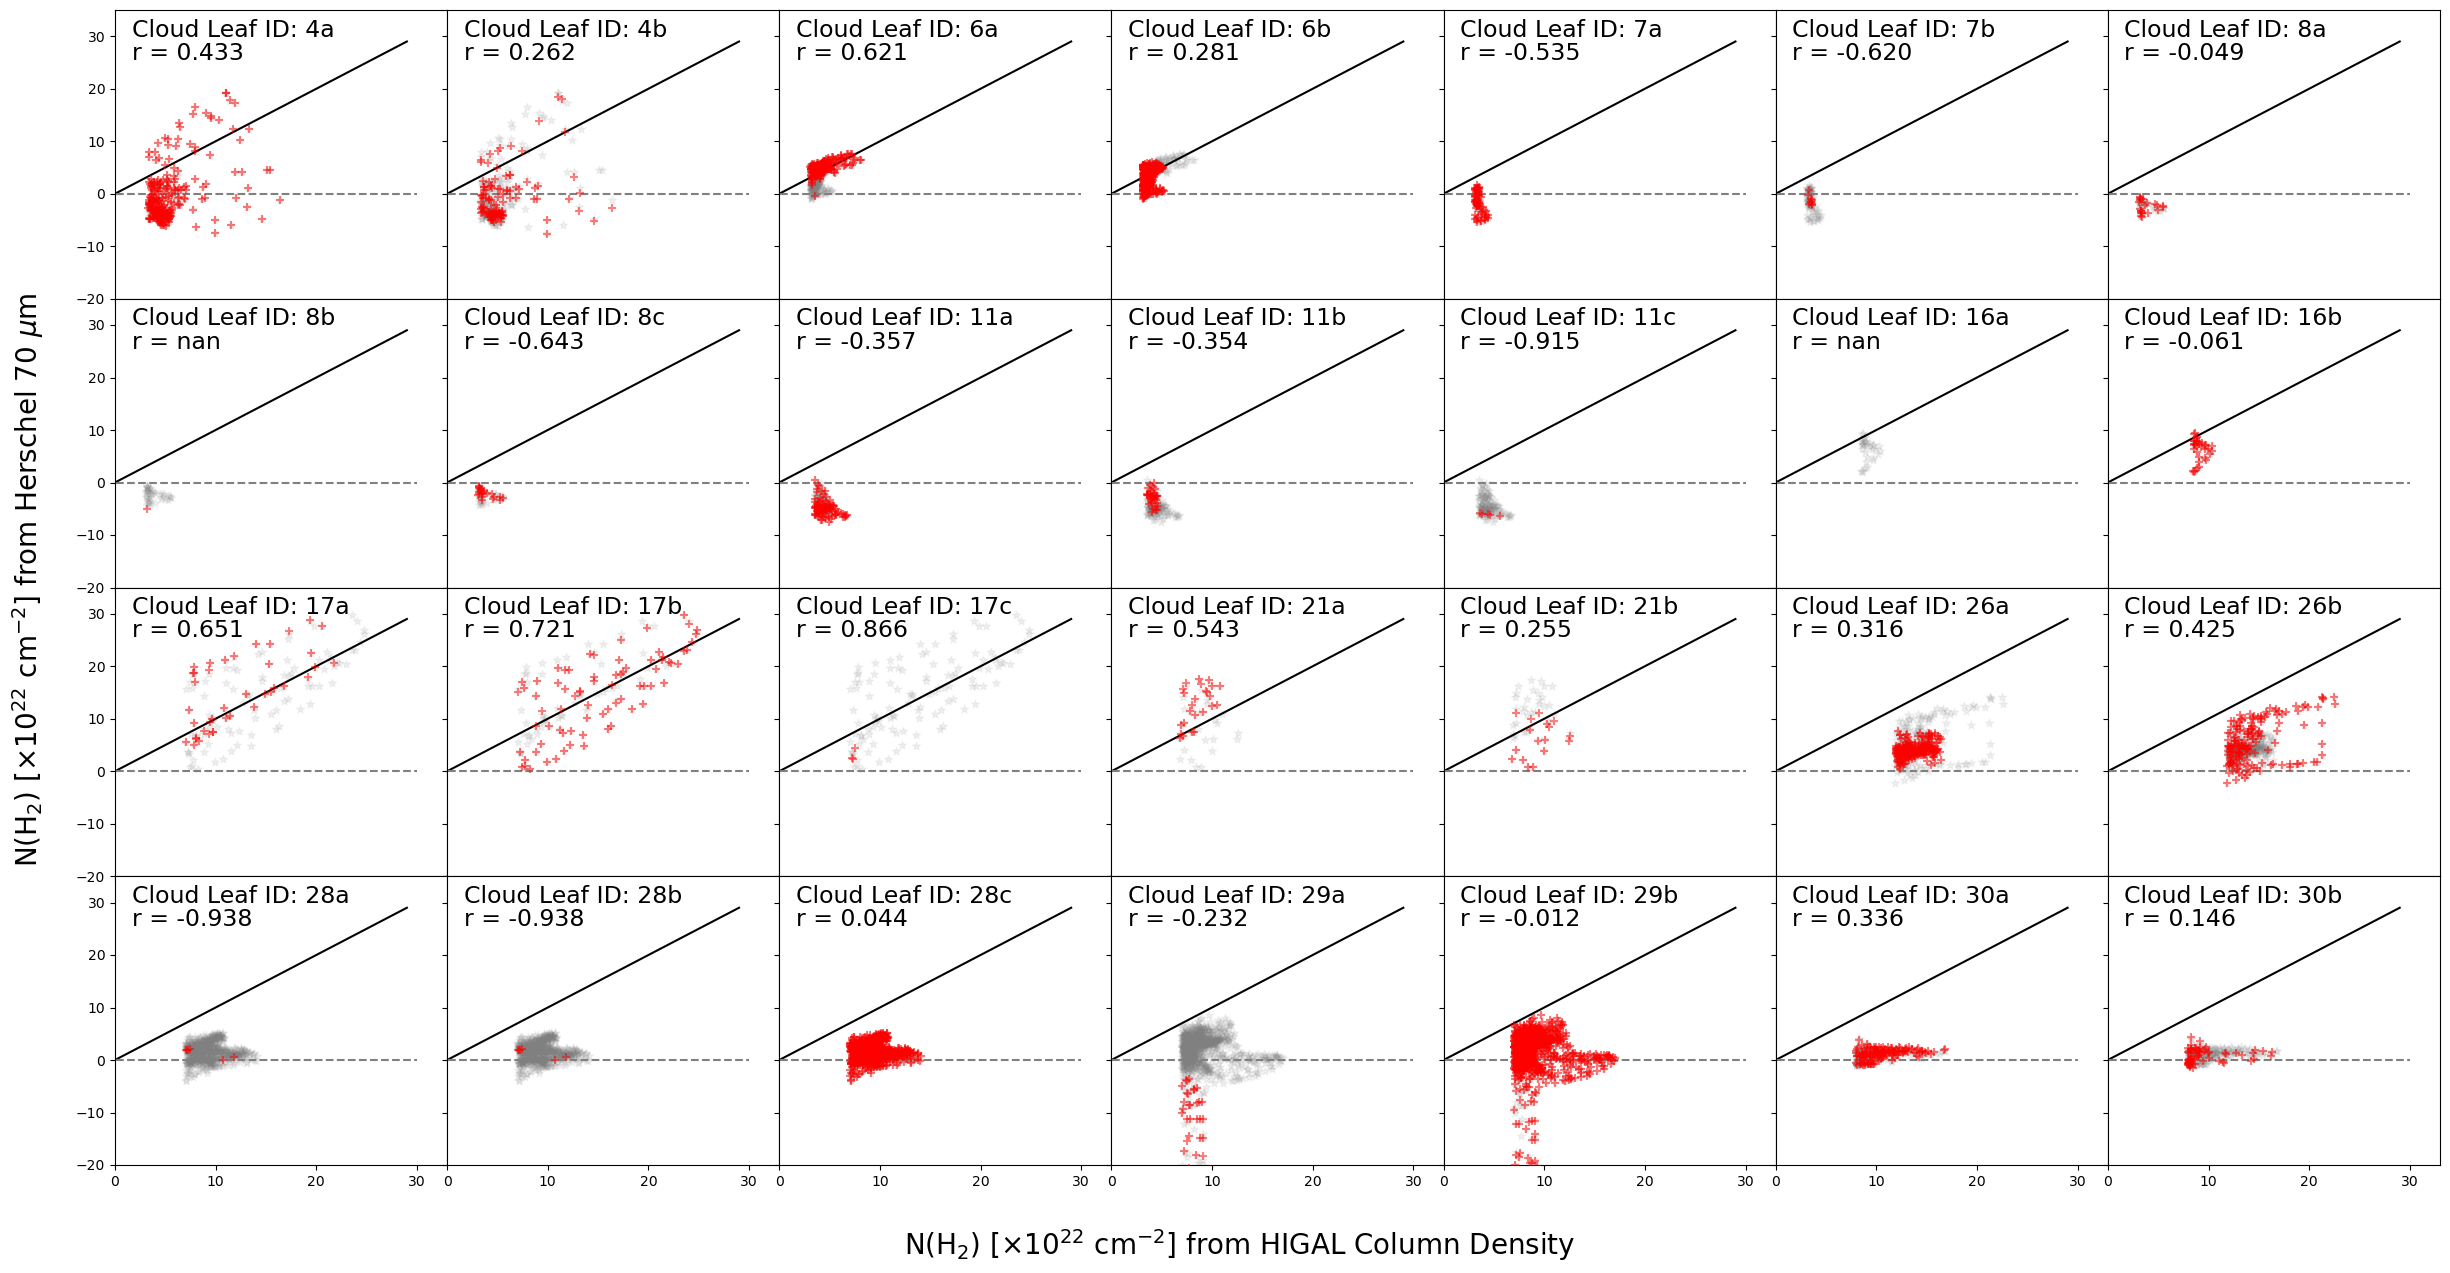

In [20]:
plot_all_the_subs(cat_index_reshape, id_list_reshape, 0.5, 'max')

In [21]:
####MAKE WITH LESS ITEMS IN EACH ROW!!!!####

cat_index_reshape = np.array(cat_index[dup_index])
cat_index_reshape=np.append(cat_index_reshape,(cat_index_reshape[-1],cat_index_reshape[-1]))
cat_index_reshape = np.reshape(cat_index_reshape,(6,5))



id_list_reshape = id_list
id_list_reshape = np.append(id_list_reshape,(id_list_reshape[-1],id_list_reshape[-1]))
id_list_reshape = np.reshape(id_list_reshape,(6,5))


index_name_list = np.array(cat_tab['index'][dup_index])
index_name_list=np.append(index_name_list,(index_name_list[-1],index_name_list[-1]))
index_name_list_reshape=np.reshape(index_name_list,(6,5))

In [33]:
def plot_all_the_subs_resized(ID, mask_id, f_fore, submask_type):


    fig, ax = plt.subplots(6, 5, sharex=True, sharey=True, figsize = (20,20))
    fig.delaxes(ax[5][4])
    fig.delaxes(ax[5][3])
    

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.xlim(0,29)
    plt.ylim(-20,35)

  
    for i in range(6):
        for j in range(5):
            
            

            id_index = np.where(cloud_leafs == int(ID[i][j]))
            cloud_name = cloud_names[id_index][0]
            

            regrided_ExtN =pyfits.open('{}/{}_submask/{}_ExtN70um_{}_ffore{:.2f}_conv36_regrid.fits'.format(ID[i][j],submask_type, mask_id[i][j], submask_type, f_fore))[0]
            #print(mask_id[i][j],np.size(np.where(~np.isnan(regrided_ExtN.data) == True)))
            
            full_regridded_ExtN = pyfits.open('../Cloud_masks/{}/{}_ExtN70um_sources_to_nans_ffore{:.2f}_cutout_smoothed_conv36_regrid_isolated.fits'.format(cloud_name, cloud_name, f_fore))[0]

            cloud_hers = pyfits.open('../Cloud_masks/{}/{}_herschel_cutout_isolated.fits'.format(cloud_name, cloud_name))[0]

            wcs = WCS(regrided_ExtN.header)
            
            
            
            #Calculate corr coeff
            
            corr_coeff_p = []
            corr_coeff_s = []
            xy_p = pd.DataFrame({'Herschel': cloud_hers.data.flatten(), 'Ext Col Den': regrided_ExtN.data.flatten()})
            corr_coeff_p.append(xy_p['Herschel'].corr(xy_p['Ext Col Den'], method='pearson'))
            
            
            xy_s = pd.DataFrame({'Herschel': cloud_hers.data.flatten(), 'Ext Col Den': regrided_ExtN.data.flatten()})
            corr_coeff_s.append(xy_s['Herschel'].corr(xy_s['Ext Col Den'], method='pearson'))
            

            plt.rcParams.update({'font.size': 15})

            
        

            x = np.arange(-1,30)
            y = np.arange(-1,30)



            ax[i,j].scatter(cloud_hers.data/1E22,regrided_ExtN.data/1E22, 
                    marker='+', color = 'r', alpha=0.5, label = "f_fore={}".format(f_fore),zorder=10)

            ax[i,j].scatter(cloud_hers.data/1E22,full_regridded_ExtN.data/1E22, 
                    marker='*', color = 'gray', alpha=0.1, label = "f_fore={}".format(f_fore), zorder=0)
            
            

            ax[i,j].plot(x,y, c='black')
            ax[i,j].hlines(0,-1, 30, linestyle='--', color='gray')

            #plt.legend(loc=2)
            #ax[i,j].text(.05, .97, '{} ({})'.format(mask_id[i][j], cloud_name), ha='left', va='top', transform=ax[i,j].transAxes)
            ax[i,j].text(.05, .97, 'Cloud Leaf ID: {}'.format(index_name_list_reshape[i][j]), fontsize=17, ha='left', va='top', transform=ax[i,j].transAxes)
            ax[i,j].text(.05, .87, 'r = {:.3f}'.format(corr_coeff_p[0]), ha='left', va='top', fontsize=17, transform=ax[i,j].transAxes)

    fig.text(0.5, 0.07, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$] from HIGAL Column Density", ha='center', fontsize=30)
    fig.text(0.07, 0.5, r"N(H$_{2}$) [$\times10^{22}$ cm$^{-2}$] from Herschel 70 $\mu$m", va='center', rotation='vertical', fontsize=30)

    
    #plt.tight_layout()
    
    plt.savefig('/Users/danilipman/Documents/Research/UConn/3D_CMZ/paper_figs/Figs/corr_coeff_submasks_{}_resized.pdf'.format(submask_type), bbox_inches='tight')


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


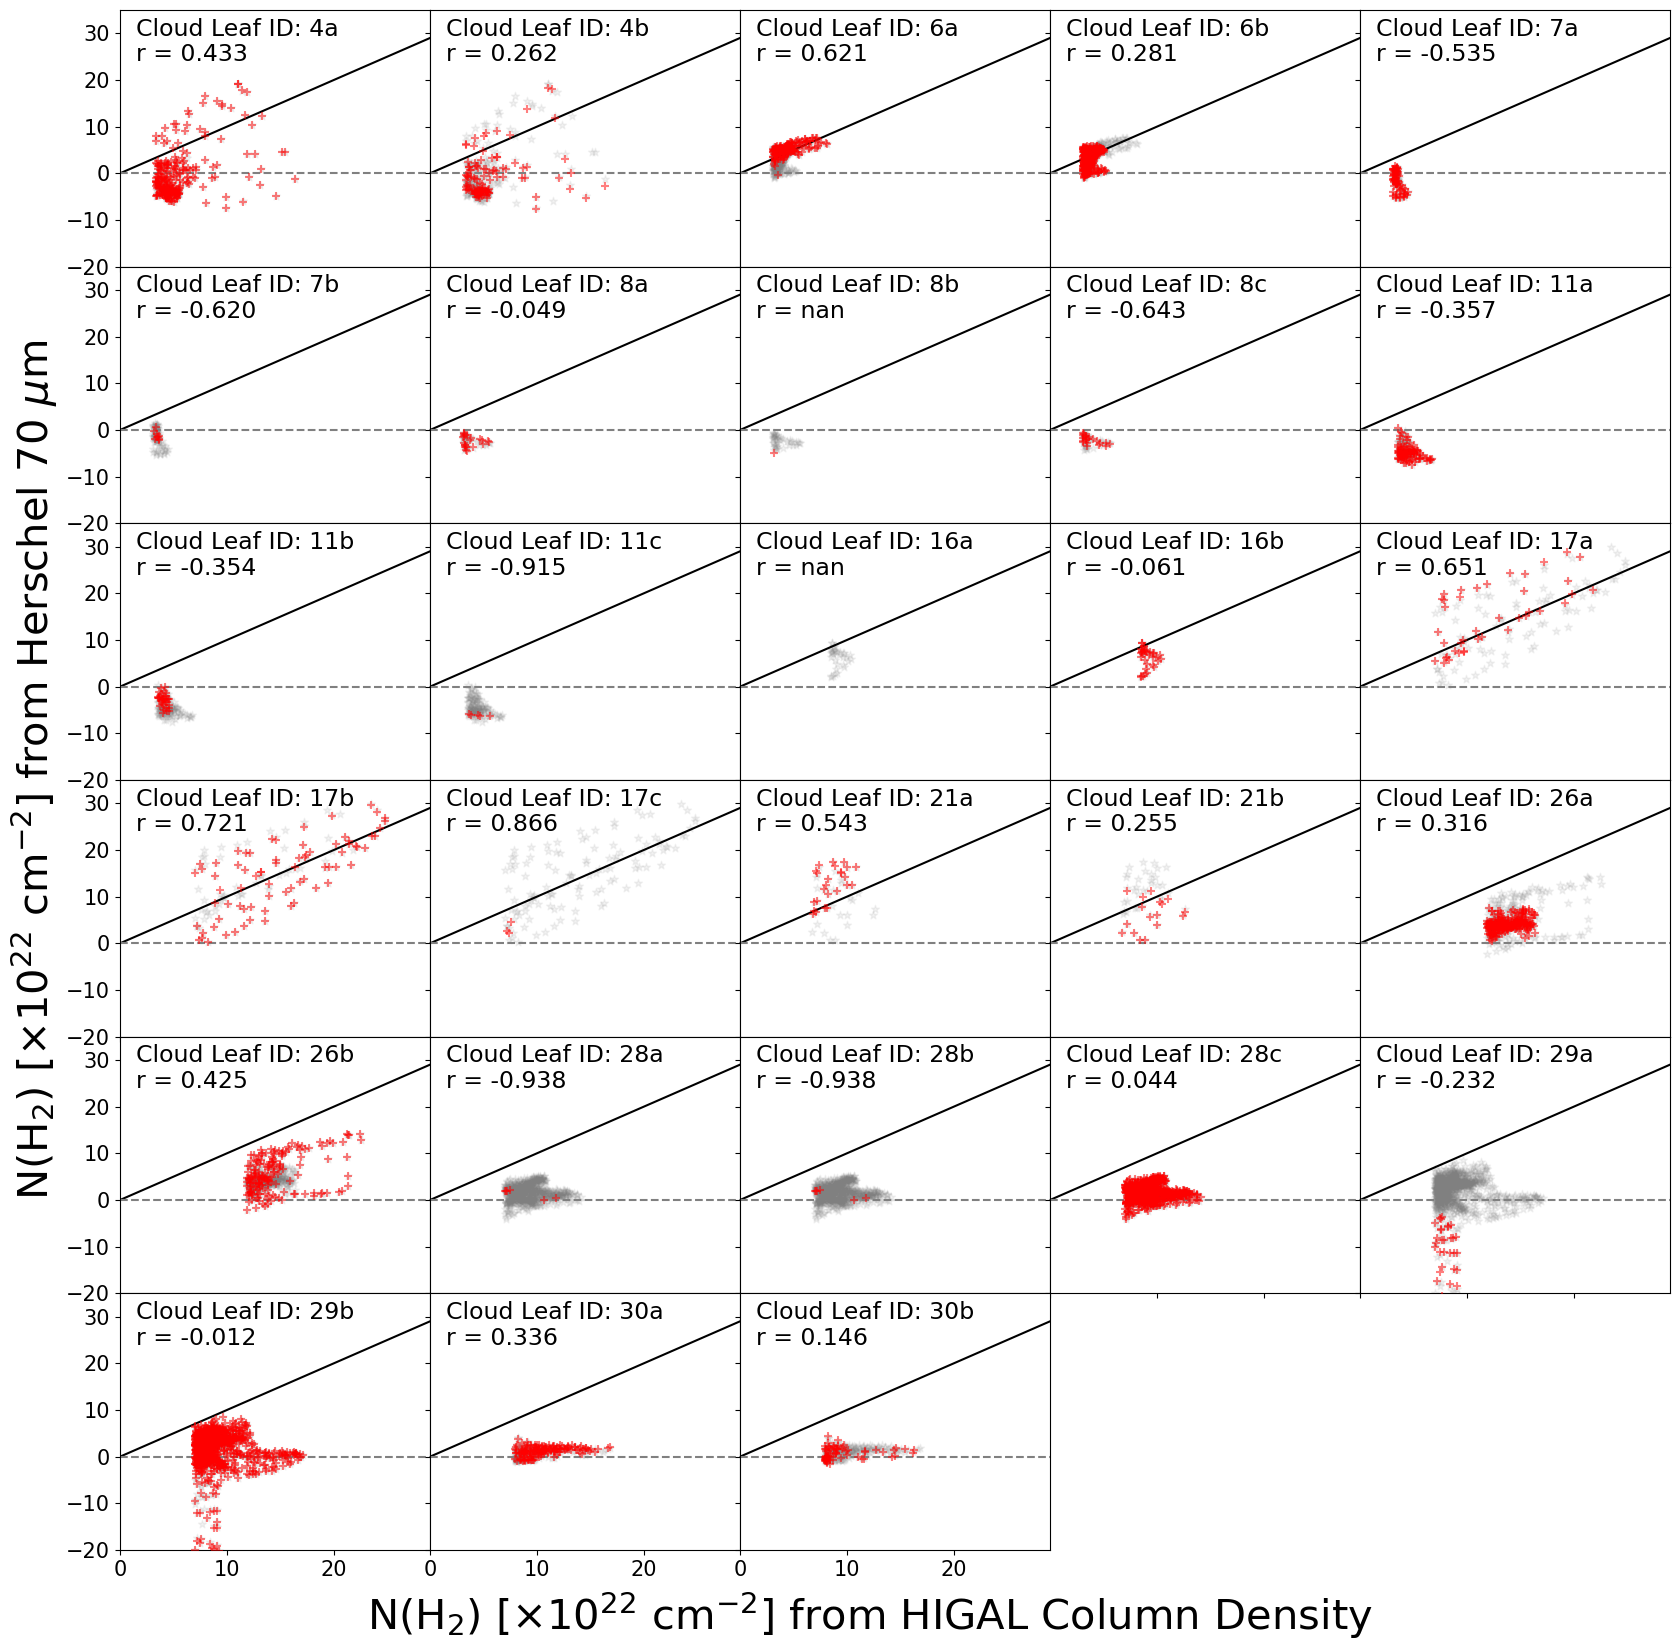

In [34]:
plot_all_the_subs_resized(cat_index_reshape, id_list_reshape, 0.5, 'max')

# Add FLUX DIFF and FLUX RATIO to table 

In [110]:
def flux_methods_sub_masks(ID, mask_id, submask_type):
    
    
    
    id_index = np.where(cloud_leafs == int(ID))
    cloud_name = cloud_names[id_index][0]   
    
    flux_diff_sub = pyfits.open('{}/{}_submask/{}_flux_diff_{}cutout_isolated.fits'.format(ID,submask_type, mask_id, submask_type))[0]
    flux_ratio_sub = pyfits.open('{}/{}_submask/{}_flux_ratio_{}cutout_isolated.fits'.format(ID,submask_type, mask_id, submask_type))[0]
    
    
    spitz_sub = pyfits.open('{}/{}_submask/{}_spitz_{}cutout_isolated.fits'.format(ID,submask_type, mask_id, submask_type))[0]
    spitz_RAW_sub = pyfits.open('{}/{}_submask/{}_spitz_RAW_{}cutout_isolated.fits'.format(ID,submask_type, mask_id, submask_type))[0]
    spitz_smoothed_sub = pyfits.open('{}/{}_submask/{}_spitz_smoothed_{}cutout_isolated.fits'.format(ID,submask_type, mask_id, submask_type))[0]
    
    cloud_ext_frac_array = spitz_sub.data/spitz_smoothed_sub.data
    
    if np.size(np.where(~np.isnan(spitz_sub.data) == True))!=0:
               ext_frac_val = np.size(np.where(cloud_ext_frac_array<1))/np.size(np.where(~np.isnan(spitz_sub.data) == True))
               
    else:
               ext_frac_val = np.nan
    
    return round(np.nanmedian(flux_diff_sub.data),3), round(np.nanmedian(flux_ratio_sub.data),3), round(ext_frac_val,3), round(np.nanmedian(spitz_sub.data),3), round(np.nanmedian(spitz_smoothed_sub.data),3), round(np.nanmin(spitz_RAW_sub.data),3)




In [113]:
os.chdir('/Users/danilipman/Documents/Research/UConn/3D_CMZ/Sub_masks/')

flux_diff_mom0 = []
flux_ratio_mom0 = []

flux_diff_max = []
flux_ratio_max = []
ext_frac_max = []
I_cloud_max = []
I_model_max = []
min_flux_max = []

for p in range(len(dup_index)):
        
#    flux_diff_sub_mom0, flux_ratio_sub_mom0 = flux_methods_sub_masks(cat_index[dup_index[p]], id_list[p], 'mom0')
#    flux_diff_mom0.append(flux_diff_sub_mom0)
#    flux_ratio_mom0.append(flux_ratio_sub_mom0)


    flux_diff_sub_max, flux_ratio_sub_max, ext_frac_val_max, I_cloud_sub_max, I_model_sub_max, min_flux_sub_max = flux_methods_sub_masks(cat_index[dup_index[p]], id_list[p], 'max')
    flux_diff_max.append(flux_diff_sub_max)
    flux_ratio_max.append(flux_ratio_sub_max)
    ext_frac_max.append(ext_frac_val_max)
    I_cloud_max.append(I_cloud_sub_max)
    I_model_max.append(I_model_sub_max)
    min_flux_max.append(min_flux_sub_max)





/var/folders/4b/_cshhy012yj8k_187jxt881r0000gn/T/ipykernel_68932/3787052692.py:24: RuntimeWarning: All-NaN slice encountered
  return round(np.nanmedian(flux_diff_sub.data),3), round(np.nanmedian(flux_ratio_sub.data),3), round(ext_frac_val,3), round(np.nanmedian(spitz_sub.data),3), round(np.nanmedian(spitz_smoothed_sub.data),3), round(np.nanmin(spitz_RAW_sub.data),3)


In [115]:
##Put Flux Ratio and flux Diff into the table for plotting###

#cat_tab['flux_diff_mom0'][dup_index] = flux_diff_mom0
#cat_tab['flux_ratio_mom0'][dup_index] = flux_ratio_mom0

cat_tab['flux_diff_max'][dup_index] = flux_diff_max
cat_tab['flux_ratio_max'][dup_index] = flux_ratio_max
cat_tab['ext_frac_max'][dup_index] = ext_frac_max
cat_tab['I_cloud_max'][dup_index] = I_cloud_max
cat_tab['I_model_max'][dup_index] = I_model_max
cat_tab['min_flux_max'][dup_index] = min_flux_max


In [116]:
cat_tab

index,cloud_name,l,b,v,sigma,rad,absorp,r_p_mom0,r_s_mom0,r_p_max,r_s_max,flux_diff_mom0,flux_ratio_mom0,I_cloud_max,I_model_max,flux_diff_max,flux_ratio_max,ext_frac_max,lb_pixel_mask,NF_decision,min_flux_max
str3,str14,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64
1,G359.475-0.044,-0.525,-0.044,-102,6,4.3,3,0.261,0.444,0.261,0.444,31.669,0.506,212.667,317.106,31.669,0.506,0.992,1,LN,nan
2,G359.508-0.135,-0.492,-0.135,-56,9,8.7,3,0.384,0.397,0.384,0.397,-20.608,0.623,224.209,276.371,-20.608,0.623,0.815,1,N,nan
3,G359.561-0.001,-0.439,-0.001,-90,8,2.7,0,0.222,0.325,0.222,0.325,-6.674,0.551,197.054,263.15,-6.674,0.551,0.997,1,U,nan
4a,G359.595-0.223,-0.405,-0.223,-27,13,4.6,3,0.468,0.257,0.433,0.254,-27.454,0.569,180.619,232.561,-26.881,0.567,0.947,1,N,100.903
4b,G359.595-0.223,-0.405,-0.223,-20,8,4.6,3,0.316,0.329,0.262,0.101,-10.883,0.517,178.699,234.446,-25.555,0.559,0.932,0,LN,100.903
5,G359.608+0.018,-0.392,0.018,-78,5,2.0,1,0.183,0.262,0.183,0.262,-26.81,0.575,185.012,230.972,-26.81,0.575,0.997,1,LN,nan
6a,G359.688-0.132,-0.312,-0.132,-29,5,5.6,0,0.655,0.694,0.621,0.621,-1.841,0.565,209.379,285.681,0.229,0.56,0.995,0,LN,153.898
6b,G359.688-0.132,-0.312,-0.132,-21,12,5.6,0,0.301,0.282,0.281,0.236,-8.637,0.579,202.07,259.951,-9.201,0.576,0.993,1,U,151.445
7a,G359.701+0.032,-0.299,0.032,-73,11,2.4,1,-0.53,-0.417,-0.535,-0.404,-45.38,0.658,205.206,233.126,-44.223,0.655,0.776,1,LN,154.551


In [120]:
#Fill in the single-component areas of the table
full_flux_method_tab = Table.read("/Users/danilipman/Documents/Research/UConn/3D_CMZ/CMZ_cat_flux_method_vals_updated.tex")
flux_method_leaf_ids = full_flux_method_tab['leaf id']
flux_diff = full_flux_method_tab['Flux Difference']
flux_ratio = full_flux_method_tab['Flux Ratio']
ext_val = full_flux_method_tab['Extinction Fraction']
I_cloud = full_flux_method_tab['I\_cloud']
I_model = full_flux_method_tab['I\_model']
min_flux = full_flux_method_tab['Min Flux']

diff_sing = []
ratio_sing =[]
extval_sing =[]
I_cloud_sing =[]
I_model_sing=[]
min_flux_sing=[]

for i in cat_tab['index'][sing_index]:
    ind = np.where(flux_method_leaf_ids == int(i))
    diff_sing.append(flux_diff[ind][0])
    ratio_sing.append(flux_ratio[ind][0])
    extval_sing.append(ext_val[ind][0])
    I_cloud_sing.append(I_cloud[ind][0])
    I_model_sing.append(I_model[ind][0])
    min_flux_sing.append(min_flux[ind][0])


cat_tab['flux_diff_mom0'][sing_index] = diff_sing
cat_tab['flux_ratio_mom0'][sing_index] = ratio_sing

cat_tab['flux_diff_max'][sing_index] = diff_sing
cat_tab['flux_ratio_max'][sing_index] = ratio_sing
cat_tab['ext_frac_max'][sing_index] = extval_sing

cat_tab['I_cloud_max'][sing_index] = I_cloud_sing
cat_tab['I_model_max'][sing_index] = I_model_sing


cat_tab['min_flux_max'][sing_index] = min_flux_sing

#cat_tab.write("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex", overwrite=True)

#cat_tab.write("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.csv", overwrite=True)


cat_tab

index,cloud_name,l,b,v,sigma,rad,absorp,r_p_mom0,r_s_mom0,r_p_max,r_s_max,flux_diff_mom0,flux_ratio_mom0,I_cloud_max,I_model_max,flux_diff_max,flux_ratio_max,ext_frac_max,lb_pixel_mask,NF_decision,min_flux_max
str3,str14,float64,float64,int64,int64,float64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,str3,float64
1,G359.475-0.044,-0.525,-0.044,-102,6,4.3,3,0.261,0.444,0.261,0.444,31.669,0.506,212.667,317.106,31.669,0.506,0.992,1,LN,82.971
2,G359.508-0.135,-0.492,-0.135,-56,9,8.7,3,0.384,0.397,0.384,0.397,-20.608,0.623,224.209,276.371,-20.608,0.623,0.815,1,N,117.934
3,G359.561-0.001,-0.439,-0.001,-90,8,2.7,0,0.222,0.325,0.222,0.325,-6.674,0.551,197.054,263.15,-6.674,0.551,0.997,1,U,106.365
4a,G359.595-0.223,-0.405,-0.223,-27,13,4.6,3,0.468,0.257,0.433,0.254,-27.454,0.569,180.619,232.561,-26.881,0.567,0.947,1,N,100.903
4b,G359.595-0.223,-0.405,-0.223,-20,8,4.6,3,0.316,0.329,0.262,0.101,-10.883,0.517,178.699,234.446,-25.555,0.559,0.932,0,LN,100.903
5,G359.608+0.018,-0.392,0.018,-78,5,2.0,1,0.183,0.262,0.183,0.262,-26.81,0.575,185.012,230.972,-26.81,0.575,0.997,1,LN,123.728
6a,G359.688-0.132,-0.312,-0.132,-29,5,5.6,0,0.655,0.694,0.621,0.621,-1.841,0.565,209.379,285.681,0.229,0.56,0.995,0,LN,153.898
6b,G359.688-0.132,-0.312,-0.132,-21,12,5.6,0,0.301,0.282,0.281,0.236,-8.637,0.579,202.07,259.951,-9.201,0.576,0.993,1,U,151.445
7a,G359.701+0.032,-0.299,0.032,-73,11,2.4,1,-0.53,-0.417,-0.535,-0.404,-45.38,0.658,205.206,233.126,-44.223,0.655,0.776,1,LN,154.551


In [71]:
#cat_tab_tex = Table.read("/Users/danilipman/Documents/Research/UConn/3D_CMZ/LBV_plots_stuff/CMZ_cloud_catalogue_data.tex")

In [85]:
full_flux_method_tab

leaf id,l,b,I\_cloud,I\_model,Flux Ratio,Extinction Fraction,Flux Difference,Min Flux
int64,float64,float64,float64,float64,float64,float64,float64,float64
1,-0.525,-0.044,212.667,317.106,0.506,0.992,31.669,82.971
2,-0.492,-0.135,224.209,276.371,0.623,0.815,-20.608,117.934
3,-0.439,-0.001,197.054,263.15,0.551,0.997,-6.674,106.365
4,-0.405,-0.223,181.049,231.695,0.557,0.938,-22.123,100.903
5,-0.392,0.018,185.012,230.972,0.575,0.997,-26.81,123.728
6,-0.312,-0.132,205.725,273.479,0.562,0.993,-5.016,151.445
7,-0.299,0.032,206.212,234.487,0.657,0.771,-44.495,154.551
8,-0.135,0.023,329.555,315.287,0.88,0.4,-87.038,197.792
9,-0.12,-0.081,195.59,315.944,0.454,0.996,47.584,126.201
